# COMP3065 Computer Vision Coursework
@author: Gaole Dai (20124917)

@email: scygd1@nottingham.edu.cn

@file: image search with SIFT & VLAD algorithm for feature extraction

@cite: code partially from https://github.com/GrigorySamokhin/Landmark-Image-Retrieval

## Installation & Mount Google Drive

In [ ]:
!pip install opencv-contrib-python==3.4.2.17
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 30.6 MB 68.8 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
Mounted at /content/drive


## Prerequisites

In [ ]:
from IPython.core.display import display_markdown
import os
import cv2
import itertools
import numpy as np
import pickle
from sklearn.cluster import KMeans
from collections import Counter
from six.moves import cPickle
from tqdm import tqdm
import matplotlib.pyplot as plt

DEPTH = 5


## SIFT Feature Descriptor

In [ ]:
def describe_SIFT(image):
  """
  :param image: image path
  Calculate SIFT descriptor with nfeatures key-points
  """
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(image, None)
  return descriptors

def get_SIFT_descriptors():
  """
  :param dataset: Object of DataSet
  Calculate set of SIFT descriptors of all images in dataset
  """
  descriptors = []

  # Compute SIFT descriptors
  print("Converting images to feature vectors:")
  for image in tqdm(os.listdir('/content/drive/MyDrive/y4_cv/oxbuild_images_100')):
      img = cv2.imread(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100', image))
      des = describe_SIFT(img)
      descriptors.append(des)

  descriptors = np.array(list(itertools.chain.from_iterable(descriptors)))
  return descriptors

descriptors = get_SIFT_descriptors()

Converting images to feature vectors:


100%|██████████| 189/189 [01:21<00:00,  2.31it/s]


## K-Means Clusters

In [ ]:
# print(descriptors)
def get_clusters(descriptors, k):
  # Compute k clusters
  clusters = KMeans(n_clusters=k).fit(descriptors)
  return clusters
kmeans_clusters_res = get_clusters(descriptors, k=12)

## VLAD Feature Extractor

In [ ]:
def compute_vlad_descriptor(descriptors, kmeans_clusters):
  """
  :param descriptor: SIFT descriptor of image
  :param kmeans_clusters: Object of Kmeans (sklearn)
  First we need to predict clusters for key-points of image (row in
  input descriptor). Then for each cluster we get descriptors, which belong to it,
  and calculate sum of residuals between descriptor and centroid (cluster center)
  """
  # Get SIFT dimension (default: 128)
  sift_dim = descriptors.shape[1]

  # Predict clusters for each key-point of image
  labels_pred = kmeans_clusters.predict(descriptors)

  # Get centers for each cluster and number of clusters
  centers_cluster = kmeans_clusters.cluster_centers_
  numb_cluster = kmeans_clusters.n_clusters
  vlad_descriptors = np.zeros([numb_cluster, sift_dim])

  # Compute the sum of residuals (for belonging x for cluster) for each cluster
  for i in range(numb_cluster):
    if np.sum(labels_pred == i) > 0:

      # Get descritors which belongs to cluster and compute residuals between x and centroids
      x_belongs_cluster = descriptors[labels_pred == i, :]
      vlad_descriptors[i] = np.sum(x_belongs_cluster - centers_cluster[i], axis=0)

  # Create vector from matrix
  vlad_descriptors = vlad_descriptors.flatten()

  # Power and L2 normalization
  vlad_descriptors = np.sign(vlad_descriptors) * (np.abs(vlad_descriptors)**(0.5))
  vlad_descriptors = vlad_descriptors / np.sqrt(vlad_descriptors @ vlad_descriptors)
  return vlad_descriptors

def get_vlad_descriptors(kmeans_clusters):
  '''
  :param kmeans_clusters: Object of Kmeans (sklearn)
  Calculate VLAD descriptors for dataset
  '''
  vlad_descriptors = []
  for image in tqdm(os.listdir('/content/drive/MyDrive/y4_cv/oxbuild_images_100')):
    img = cv2.imread(os.path.join('/content/drive/MyDrive/y4_cv/oxbuild_images_100', image))
    descriptor = describe_SIFT(img)
    # Compute VLAD descriptors
    vlad_descriptor = compute_vlad_descriptor(descriptor, kmeans_clusters)
    vlad_descriptors.append({'image_name': image, 'feature_vector': vlad_descriptor})
  return vlad_descriptors

# Compute VLAD descriptors
vlad_descriptors = get_vlad_descriptors(kmeans_clusters_res)

# Save the clusters and descriptors
with open('/content/drive/MyDrive/y4_cv/vlad_descriptors.pkl', 'wb') as f:
  pickle.dump(vlad_descriptors, f)

with open('/content/drive/MyDrive/y4_cv/kmeans_clusters.pkl', 'wb') as f:
  pickle.dump(kmeans_clusters_res, f)

100%|██████████| 189/189 [01:21<00:00,  2.31it/s]


## Predictions

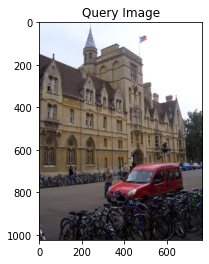

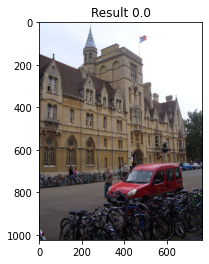

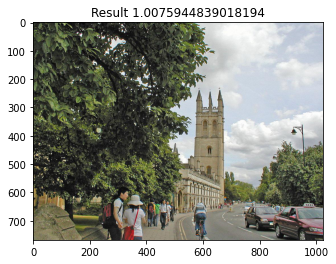

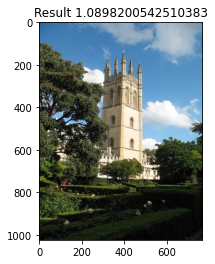

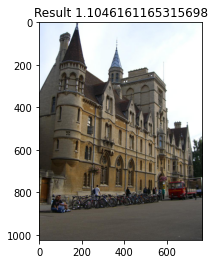

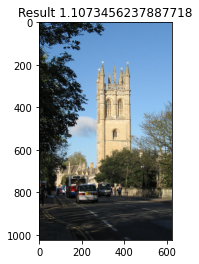

In [ ]:
def get_prediction(kmeans_clusters, vlad_descriptors, query):
  """
  :param kmeans_clusters: Object of Kmeans (sklearn)
  :param vlad_descriptors: Set of VLAD descriptions
  Calculate VLAD vector for query image, and then
  get best distances in dataset.
  """

  list_res = []
  # compute SIFT descriptor for query
  img = cv2.imread(query)
  descriptor = describe_SIFT(img)

  # compute VLAD descriptor for query
  v = compute_vlad_descriptor(descriptor, kmeans_clusters)

  # Get distances between query VLAD and dataset VLADs descriptors
  for i in range(len(vlad_descriptors)):
    temp_vec = vlad_descriptors[i]['feature_vector']
    dist = np.linalg.norm(temp_vec - v)
    list_res.append({'i': i,
            'dist': dist,
            'image_name':vlad_descriptors[i]['image_name']})
  res_ = sorted(list_res, key=lambda x: x['dist'])

  return res_[:DEPTH]

  print('\nPredicted class for query image: {}.'.format(res))


query_img = '/content/drive/MyDrive/y4_cv/oxbuild_images_100/balliol_000051.jpg'

results = get_prediction(kmeans_clusters_res, vlad_descriptors, query_img)

plt.imshow(np.array(plt.imread(query_img), dtype=int))
plt.title('Query Image')
plt.show()

for i, vectors in enumerate(results):
    image_path = '/content/drive/MyDrive/y4_cv/oxbuild_images_100/' + vectors['image_name']
    image = np.array(plt.imread(image_path), dtype=int)
    plt.title('Result {}'.format(vectors['dist']))
    plt.imshow(image)
    plt.show()